<a href="https://colab.research.google.com/github/ubaldinho/Hello_World/blob/main/PW1_FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FGSM Attack

In this section, we demonstrate how to perform an adversarial attack on a classification model using the Fast Gradient Sign Method (FGSM).

First, we import all packages required for this practical work:

In [1]:
from torch import nn
import torch

from src.data import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

The following cell loads the CIFAR-10 dataset and a pre-trained ResNet-18 architecture. The final fully connected layer of the model is then modified to output 10 features, corresponding to the 10 classes in the CIFAR-10 dataset.  

Next, load the weights of the trained model model\_cifar10.pth by following the PyTorch documentation:   https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [5]:
train_set, test_set = CIFAR10() # Load the dataset

model = torch.hub.load('pytorch/vision', 'resnet18', weights=None) # Load the model architecture
model.fc = nn.Linear(model.fc.in_features, 10) # Set the last layer as a fully connected layer
PATH_model = "/content/src/model_cifar10.pth"
model.load_state_dict(torch.load(PATH_model, weights_only=True)) # TODO : (a) Load the weights of the trained model
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This cell defines and prints the labels of the CIFAR-10 dataset.  
The dataset consists of 10 classes, each representing a different object category.

In [3]:
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
] # Define the labels of the dataset

for i, label in enumerate(cifar10_labels): # Print the labels
    print(f"{i} : {label}")

0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck


This cell sets the model to evaluation mode and performs predictions on five images. It then displays the images together with their ground-truth labels and the model’s predicted labels.


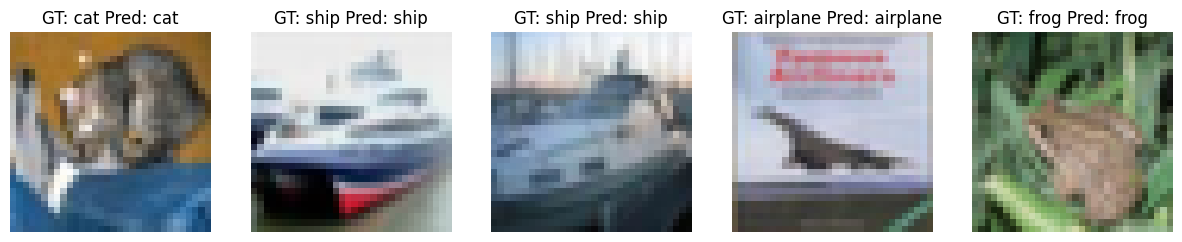

In [4]:
model.eval() # Set the model to evaluation mode

dataiter = iter(test_set) # Get an iterator over the test set
images, labels = next(dataiter) # Get a batch of images and labels

# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show images with ground truth and predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axes[i]
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title(f"GT: {cifar10_labels[labels[i].item()]} Pred: {cifar10_labels[predicted[i].item()]}")
    ax.axis('off')
plt.show()

This cell takes an image and passes it through the model to obtain class predictions. The softmax function is then applied to convert the model’s output into probabilities. Finally, a bar chart is plotted to show the model’s confidence for each class label of the selected image.  

Plot the model’s confidence for the Concorde image. Is the model confident that the image represents an airplane?


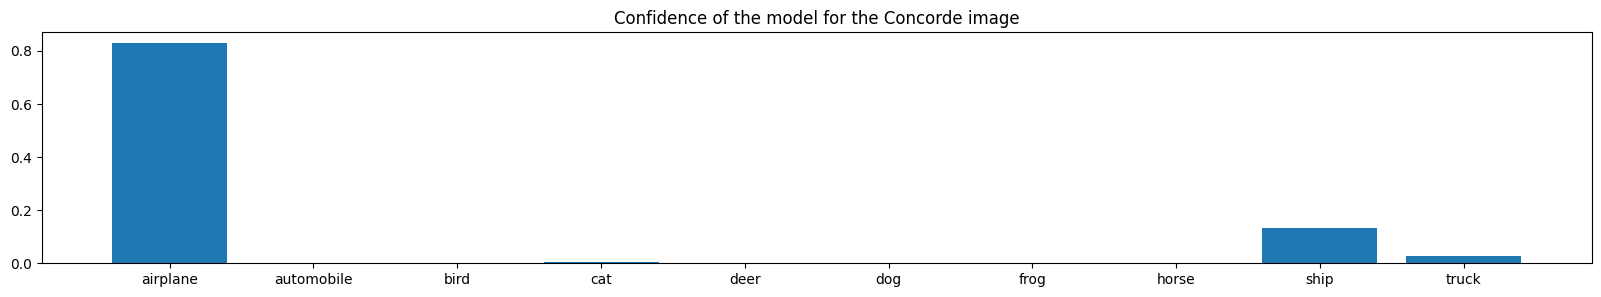

In [6]:
image = images[3].unsqueeze(0)# TODO : (c) Set the variable image as the Conorde image using the tensor images. You may need to use .unsqueeze(0) to add a batch dimension
softmax = torch.nn.Softmax(dim=1)
proba = softmax(model(image).detach()).numpy()[0]
plt.figure(figsize=(20, 3))
plt.bar(cifar10_labels, proba)
plt.title("Confidence of the model for the Concorde image")
plt.show()

## Untargetted Attack

You can see that, according to its confidence in certain predictions, the model is generally able to provide a good answer for most inputs. However, it can still be fooled. In particular, if we take $x$ to be an image of the Concorde, for which the model outputs $F_\theta(x) = 0$ (i.e., $x$ is classified as an airplane), we can construct an image $\hat{x}$ that looks visually identical, but such that $F_\theta(\hat{x}) \neq 0$ (i.e., $\hat{x}$ is assigned to a different class). To achieve this, we will investigate the Fast Gradient Sign Method (FGSM). This technique consists, for an input $x$ and its corresponding label $y$, in creating $\hat{x}$ as follows:

$$\hat{x} =  x + \epsilon \times \text{sign} \left( \nabla_{x} J \left( \theta, x, y \right) \right) $$

Let us break down this formula. First, we need to compute $\nabla_{x} J \left( \theta, x, y \right)$, which corresponds to the gradient of the loss function $J$ with respect to the input $x$, evaluated at $(\theta, x, y)$.

Define $x$ as the Concorde image and $y$ as the "airplane" label:


In [7]:
x = image # TODO (d) : Define the Concorde image
y = torch.tensor(0)# TODO (d) : Define the airplane label

We let PyTorch compute the gradient of the loss function $J$ with respect to the input $x$:


In [8]:
x.requires_grad = True

We define the loss function $J$ as the cross-entropy loss, following the PyTorch documentation and using the default parameters (https://pytorch.org/docs/stable/nn.html) :

In [9]:
J = nn.CrossEntropyLoss() # TODO (d) : Define the loss function

Now we compute $\nabla_{x} J \left( \theta,x,y \right)$ :

In [10]:
y_tilde = model(x)
loss = J(y_tilde, y.unsqueeze(0))
loss.backward()

The value of $\nabla_{x} J \left( \theta, x, y \right)$ is stored in ```x.grad```. Using this, and the ```torch.sign``` function, we can define $x + \epsilon \times \text{sign} \left( \nabla_{x} J \left( \theta, x, y \right) \right)$ with an arbitrary value of $\epsilon$:

In [11]:
epsilon = 0.005  # Define an arbitrary epsilon value
perturbation =  torch.sign(x.grad)
adversarial_image = x + epsilon * perturbation # TODO (d) : Define the adversarial image

The model's prediction for the adversarial image is:

In [12]:
averarial_predicted = model(adversarial_image).argmax().cpu()

Let us show the final result:

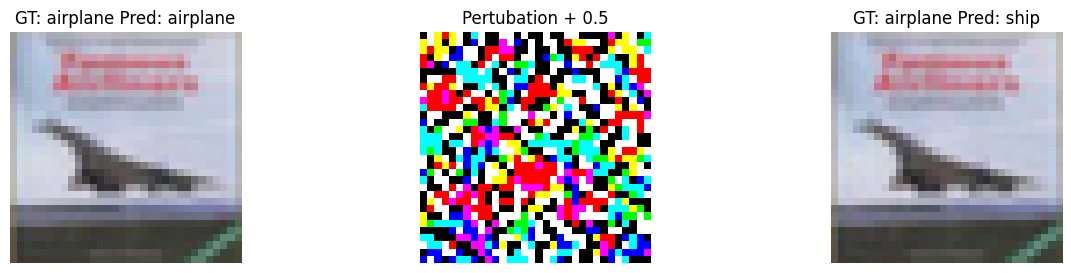

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
ax = axes[0]
ax.imshow(np.transpose(image[0].detach().numpy(), (1, 2, 0)))
ax.set_title(f"GT: {cifar10_labels[labels[3].item()]} Pred: {cifar10_labels[predicted[3].argmax().item()]}")
ax.axis('off')
ax = axes[1]
ax.imshow(np.transpose((perturbation)[0].detach().cpu().numpy(), (1, 2, 0)) + 0.5)
ax.set_title(f"Pertubation + 0.5")
ax.axis('off')
ax = axes[2]
ax.imshow(np.transpose(adversarial_image[0].detach().cpu().numpy(), (1, 2, 0)))
ax.set_title(f"GT: {cifar10_labels[labels[3].item()]} Pred: {cifar10_labels[averarial_predicted.item()]}")
ax.axis('off')
plt.show()

Show the corresponding confidence:

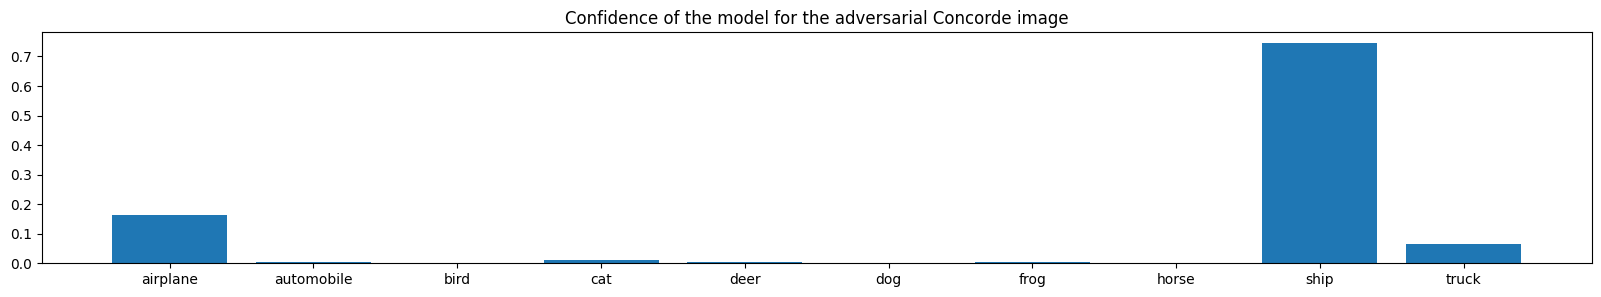

In [15]:
proba = softmax(model(adversarial_image).detach()).numpy()[0]
plt.figure(figsize=(20, 3))
plt.bar(cifar10_labels, proba)
plt.title("Confidence of the model for the adversarial Concorde image")
plt.show()

## Targeted attack

As you can see, we indeed have $F_\theta(\hat{x}) = \tilde{y}$, where $\tilde{y} \neq 0$. However, we cannot control the value of $\tilde{y}$ because we are simply maximizing the loss with respect to the initial label $y$. Let us now specify the target class that we want the model to predict for this image. To do so, we apply

\begin{equation}
    \hat{x} =  x - \epsilon \times \text{sign} \left( \nabla_{x} J \left( \theta, x, \hat{y} \right) \right)
\end{equation}

from which we can observe two changes: first, there is a minus sign, which appears because we aim to minimize the loss (as in gradient descent); and second, the loss is computed using $\hat{y}$ as the target.

Using what we have done previously, we define the adversarial image for the targeted attack as:

In [16]:
# TODO (e) : Implement the targetted attack
x = images[3].unsqueeze(0) # TODO (d) : Define the Concorde image
y = torch.tensor(3) # TODO (d) : Define the airplane label
x.requires_grad = True
J = nn.CrossEntropyLoss() # TODO (d) : Define the loss function
y_tilde = model(x)
loss = J(y_tilde, y.unsqueeze(0))
loss.backward()
epsilon = 0.05  # Define an arbitrary epsilon value
perturbation = torch.sign(x.grad)
targetted_adversarial_image = x - epsilon * perturbation

In [17]:
adversarial_predicted = model(targetted_adversarial_image).argmax().cpu()

Show the result :

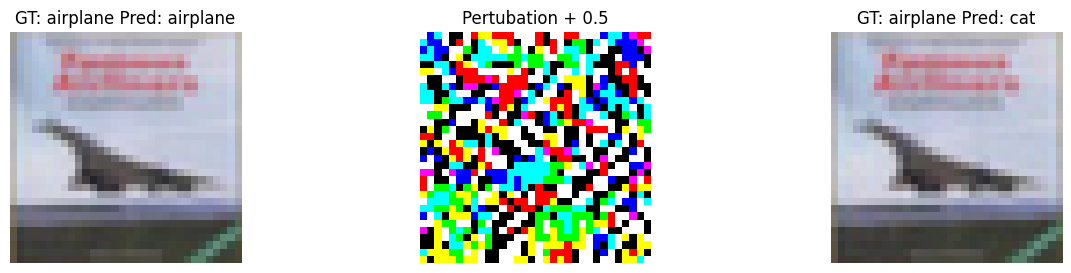

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
ax = axes[0]
ax.imshow(np.transpose(image[0].detach().numpy(), (1, 2, 0)))
ax.set_title(f"GT: {cifar10_labels[labels[3].item()]} Pred: {cifar10_labels[predicted[3].argmax().item()]}")
ax.axis('off')
ax = axes[1]
ax.imshow(np.transpose((perturbation)[0].detach().cpu().numpy(), (1, 2, 0)) + 0.5)
ax.set_title(f"Pertubation + 0.5")
ax.axis('off')
ax = axes[2]
ax.imshow(np.transpose(adversarial_image[0].detach().cpu().numpy(), (1, 2, 0)))
ax.set_title(f"GT: {cifar10_labels[labels[3].item()]} Pred: {cifar10_labels[adversarial_predicted.item()]}")
ax.axis('off')
plt.show()

Show the corresponding confidence :

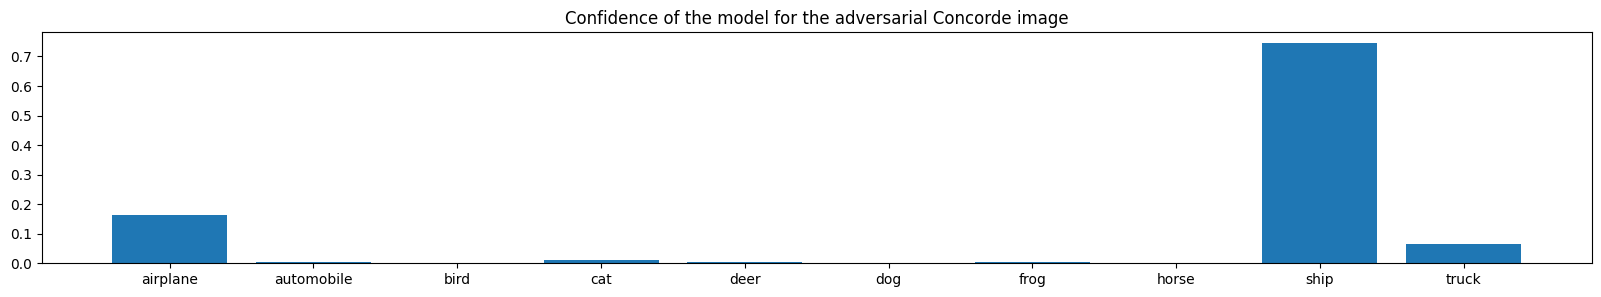

In [20]:
proba = softmax(model(adversarial_image).detach()).numpy()[0]
plt.figure(figsize=(20, 3))
plt.bar(cifar10_labels, proba)
plt.title("Confidence of the model for the adversarial Concorde image")
plt.show()